In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.metrics import accuracy_score

In [3]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

Let's review last time and run through a few of the methods we've discussed so far:

We built decision trees for regression last time. That meant we partition feature space by repeatedly choosing a cut point for the variable that gives the maximal reduction in RSS.

<img src="TreePic.png">

Terminal nodes in the tree become increasingly pure (all values in a node are close to the average).

Growing deep trees lead to low bias (might have enough nodes so that training error is 0) but high variance and poor generalizablity to test data.

In order to reduce variance and improve performance on new data we introduced the idea of cost complexity pruning...

Grow a deep tree and prune it back by removing nodes that provide the least benefit in RSS. Did this by minimizing RSS plus a penalty on the tree depth (complexity). 

This is very much like Ridge regression. Optimize the penalty parameter $\alpha$ using cross validation.

#### Example

We were using NBA player salary data.

In [4]:
pl=pd.read_csv('players.csv')
sal=pd.read_csv('salaries_1985to2018.csv')

In [5]:
gp_sal=sal[['player_id','salary','season_end']].groupby('player_id',as_index=False).mean()
players=pl.merge(gp_sal,how='left',left_on='_id',right_on='player_id')
players=players[players['salary'].notnull()]

In [6]:
players.columns

Index(['_id', 'birthDate', 'birthPlace', 'career_AST', 'career_FG%',
       'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS',
       'career_TRB', 'career_WS', 'career_eFG%', 'college', 'draft_pick',
       'draft_round', 'draft_team', 'draft_year', 'height', 'highSchool',
       'name', 'position', 'shoots', 'weight', 'player_id', 'salary',
       'season_end'],
      dtype='object')

In [7]:
players['logsalary']=np.log(players['salary'])
players['logG'] =np.log(players['career_G'])
pdf=players[['career_AST', 'career_FG%','career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS','career_TRB', 'career_WS', 'career_eFG%',
       'logsalary', 'logG','season_end']].copy()

In [8]:
pdf.head()

,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,logsalary,logG,season_end
0,0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,13.251284,5.545177,1993.000000
2,3.6,55.9,5.6,72.1,1560,24.6,24.6,11.2,273.4,55.9,14.576316,7.352441,1987.000000
3,3.5,44.2,35.4,90.5,586,15.4,14.6,1.9,25.2,47.2,14.606465,6.373320,1995.222222
4,1.1,41.7,23.7,70.3,236,11.4,7.8,3.3,3.5,42.2,15.150059,5.463832,2002.500000
5,2.5,47.2,29.7,81.0,830,19.0,18.1,7.5,71.2,47.9,15.980567,6.721426,2003.909091


In [9]:
pdf['career_FG%']=pd.to_numeric(pdf['career_FG%'],errors='coerce')
pdf['career_FG3%']=pd.to_numeric(pdf['career_FG3%'],errors='coerce')
pdf['career_FT%']=pd.to_numeric(pdf['career_FT%'],errors='coerce')
pdf['career_PER']=pd.to_numeric(pdf['career_PER'],errors='coerce')
pdf['career_TRB']=pd.to_numeric(pdf['career_TRB'],errors='coerce')
pdf['career_WS']=pd.to_numeric(pdf['career_WS'],errors='coerce')
pdf['career_eFG%']=pd.to_numeric(pdf['career_eFG%'],errors='coerce')

In [10]:
pdf=pdf.dropna()

In [11]:
pdf.head()

,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,logsalary,logG,season_end
0,0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,13.251284,5.545177,1993.000000
2,3.6,55.9,5.6,72.1,1560,24.6,24.6,11.2,273.4,55.9,14.576316,7.352441,1987.000000
3,3.5,44.2,35.4,90.5,586,15.4,14.6,1.9,25.2,47.2,14.606465,6.373320,1995.222222
4,1.1,41.7,23.7,70.3,236,11.4,7.8,3.3,3.5,42.2,15.150059,5.463832,2002.500000
5,2.5,47.2,29.7,81.0,830,19.0,18.1,7.5,71.2,47.9,15.980567,6.721426,2003.909091


In [12]:
X=pdf.drop('logsalary',axis=1)
y=pdf['logsalary']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)

In [14]:
full_tree = DecisionTreeRegressor(random_state=2).fit(X_train,y_train)

In [15]:
mean_squared_error(full_tree.predict(X_train), y_train)

6.260800835087395e-33

In [16]:
full_tree.get_depth()

24

In [17]:
np.round(mean_squared_error(full_tree.predict(X_test), y_test),3)

0.59

In [18]:
full_tree.score(X_test,y_test)

0.6436513823076471

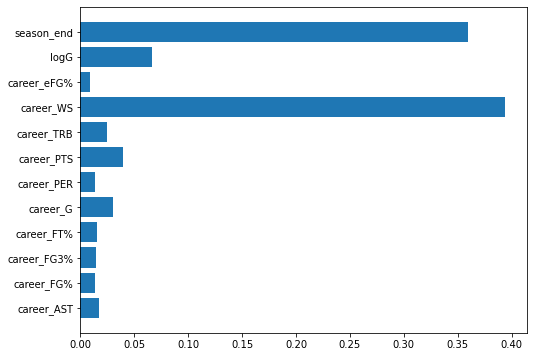

In [19]:
plt.figure(figsize=(8,6))
nfeat=X.shape[1]
plt.barh(np.arange(nfeat),full_tree.feature_importances_,align='center')
plt.yticks(np.arange(nfeat),list(X.columns))
plt.ylim(-1,nfeat)
plt.show()

Last time we didn't include season_end... but it's an important feature and adds considerably to the model.

Now, we know tyhat the full tree overfits, so we use cost complexity pruning to improve prediction:

In [20]:
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

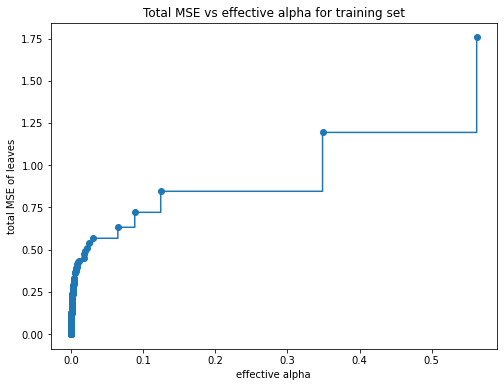

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total MSE of leaves")
ax.set_title("Total MSE vs effective alpha for training set")
plt.show()

See that as we prune back the tree (make it shorter), the bias increases: nodes become less pure, and MSE increases. The hope is that this decreases overfitting and variance and leads to better generalizability.

In [22]:
len(ccp_alphas)

1409

In [23]:
regs = []
for ccp_alpha in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    reg.fit(X_train, y_train)
    regs.append(reg)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      regs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.5623797016621641


The last tree with the largest value of alpha penalizes deep trees so much that we have depth 3.

In [24]:
regs = regs[:-1]
ccp_alphas = ccp_alphas[:-1]

In [25]:
node_counts = [reg.tree_.node_count for reg in regs]

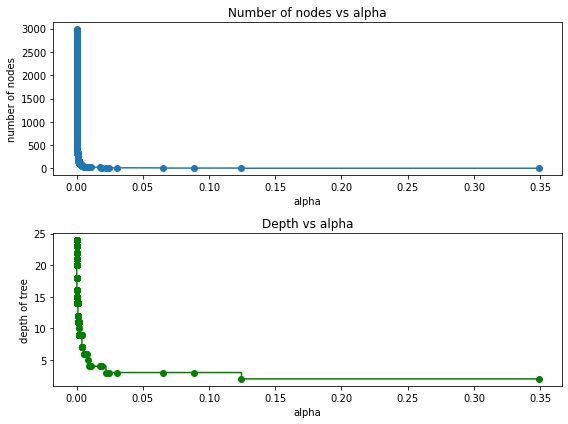

In [26]:
node_counts = [reg.tree_.node_count for reg in regs]
depth = [reg.tree_.max_depth for reg in regs]
fig, ax = plt.subplots(2, 1,figsize=(8,6))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post",color='g')
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

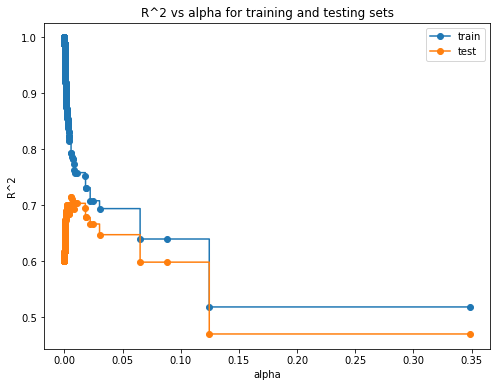

In [27]:
train_scores = [reg.score(X_train, y_train) for reg in regs]
test_scores = [reg.score(X_test, y_test) for reg in regs]

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("R^2")
ax.set_title("R^2 vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

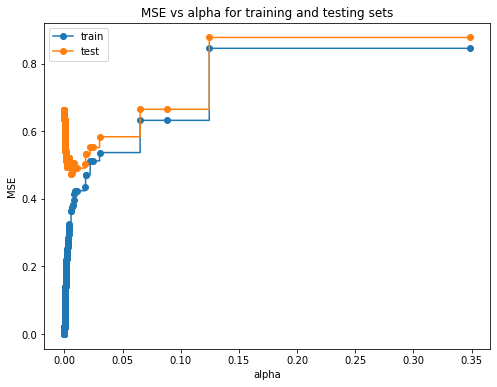

In [28]:
train_scores = [mean_squared_error(reg.predict(X_train), y_train) for reg in regs]
test_scores = [mean_squared_error(reg.predict(X_test),y_test) for reg in regs]

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

These are useful pictures to understand what is happening, but we're cheating by using the test set to get a sense of where the optimal alpha lives (note: between 0 and 0.05). 

The right way to find the optimal alpha is cross validation. This is computationally expensive: for each possible value of alpha we build the decision tree regressor on 4 training folds and validate on the hold-out test fold. We repeat 5 times using each fold as the test fold once. Keep track of the average CV error. But number of models we're building here is the length of the list of alphas (1400) times 5.

** WARNING ** the cell below is slow to run on the full list of alphas.

In [29]:
cvres=[]
for a in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=0, ccp_alpha= a)
    cvreg = cross_validate(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cvres.append(cvreg['test_score'].mean())

In [30]:
np.argmax(cvres)

1392

In [31]:
ccp_alphas[1392]

0.00717800581053344

In [32]:
optalp=ccp_alphas[np.argmax(cvres)]
optalp

0.00717800581053344

Note: this alpha--obtained via cross validation--agrees with what we expected from the pictires above on the test set. 

Now re-fit with ```optalp``` on the full training set.

In [33]:
regO = DecisionTreeRegressor(random_state=0, ccp_alpha=optalp).fit(X_train,y_train)

How deep is this tree? How does it compare to the full tree?

In [34]:
print(regO.get_depth(),':',full_tree.get_depth())

6 : 24


Compare
metrics:

In [35]:
print("The pruned tree has R-squared score {} while the full tree has R-squared {}".format(regO.score(X_test,y_test),full_tree.score(X_test,y_test)))

The pruned tree has R-squared score 0.7011602638299941 while the full tree has R-squared 0.6436513823076471


In [36]:
print("The pruned tree has mean-squared-error score {} while the full tree has mean-squared-error {}".format(mean_squared_error(regO.predict(X_test),y_test),mean_squared_error(full_tree.predict(X_test),y_test)))

The pruned tree has mean-squared-error score 0.4951354602857112 while the full tree has mean-squared-error 0.5904195978238492


The pruned tree is significantly better on both metrics. 

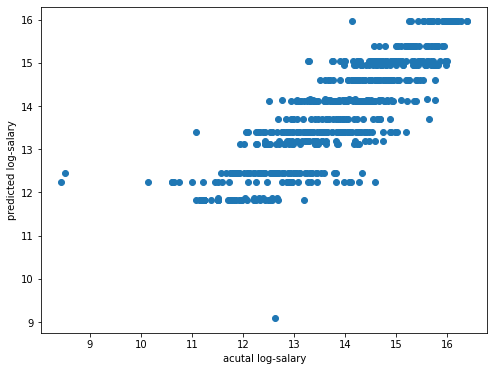

In [37]:
plt.figure(figsize = (8,6))
plt.scatter(y_test,regO.predict(X_test))
plt.xlabel("acutal log-salary")
plt.ylabel("predicted log-salary")
plt.show()

We've been working with trees, but is it worth it? Are we doing better than plain old linear regression?

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
ols=LinearRegression().fit(X_train,y_train)
mean_squared_error(ols.predict(X_test),y_test)

0.4366046371477958

In [40]:
ols.score(X_test,y_test)

0.7364866283247826

Alas, still not better than OLS regression! Maybe Ridge regression is better?

In [41]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [42]:
alphas = 10**np.linspace(5,-3,100)

In [43]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

/home/hamstersnail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


0.004430621457583878

In [44]:
ridgemod = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridgemod.fit(X_train, y_train)

/home/hamstersnail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


Ridge(alpha=0.004430621457583878, normalize=True)

In [45]:
y_pred=ridgemod.predict(X_test)
mean_squared_error(y_test, y_pred)

0.43591660349203437

In [46]:
ridgemod.score(X_test,y_test)

0.7369018920508854

Virtually no improvement using Ridge Regression here.

Maybe ***knn*** regression?

In [47]:
from sklearn.neighbors import KNeighborsRegressor

In [48]:
knn_cv_results=[]
for k in range(1,50):
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    cv_nn = cross_validate(knn_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    knn_cv_results.append(cv_nn['test_score'].mean())

In [49]:
np.argmax(knn_cv_results)

6

In [50]:
knn_reg_model=KNeighborsRegressor(n_neighbors=7).fit(X_train, y_train)

In [51]:
knn_reg_model.score(X_test,y_test)

0.6640272568462179

Worse! Let's see if we can improve our tree regressor. 

WARNING: Comparing different models' performances on the test set in order to choose the best one is *also* cheating. We really need a trianing set, a validation set, and a test set.

First idea:

#### Bagging

Idea: Create many decision trees (grown deep: no pruning). We know they will overfit-- i.e, will have high variance.

Reduce variance by *averaging*. People's heights will have much more variation then average heights of groups of 10 people. If we had many trees, and averaged their results, we might get a lower bias model with reduced variance.

Indeed, if a random variable $X$ has variance $\sigma^2$ then the distribution of the sample mean $\overline{X}$ has variance $\frac{\sigma^2}{\sqrt{n}}$ where $n$ is sample size.

Problem: there's only one training set-- so how do we fit different trees to average? 

The bootstrap.

### A short digression on bootstrapping

Back to Boston marathon, 2017. Let's look at the distribution of runners' paces (in minutes per mile):

In [52]:
mar=pd.read_csv('marathon_results_2017.csv')

In [53]:
def to_minutes(row):
    x= row['Official Time'].split(":")
    return (int(x[0])*3600+int(x[1])*60+int(x[2]))/(60*26.2)
mar['Pace']=mar.apply(to_minutes,axis=1)

<AxesSubplot:>

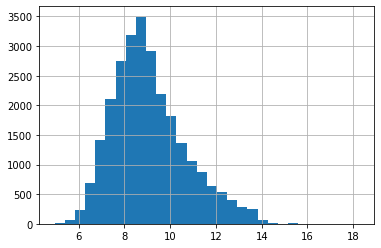

In [54]:
mar['Pace'].hist(bins=30)

We actually know the true populaiton mean/median paces: This is ***everyone***, not a sample.

In [55]:
print("Mean time: {}".format(np.round(mar['Pace'].mean(),3)), "Median Time: {}".format(np.round(mar['Pace'].median(),3)))

Mean time: 9.086 Median Time: 8.842


But what if we did only have a sample? Say of 100 results?

In [56]:
samp=mar.sample(n=100,random_state=10)

Sample mean and median:

In [57]:
print(np.round(samp['Pace'].mean(),3),":",np.round(samp['Pace'].median(),3))

9.283 : 8.912


A typical problem in statistics is to use the sample data to give a 95% confidence interval for the mean: an interval which captures the true (fixed) population mean witrh probability 0.95.

In [58]:
samp['Pace'].std()

1.8033609476886534

In [59]:
from scipy import stats

In [60]:
t_crit = np.abs(stats.t.ppf((1-.95)/2,99)) 
t_crit

1.9842169515086827

Slightly bigger than the ```z_crit``` of 1.96

$$
\overline{x} \pm t_{.95,df}\cdot\frac{s}{\sqrt{n}}
$$

In [61]:
print("(",samp['Pace'].mean()-t_crit*samp['Pace'].std()/np.sqrt(100),",",
samp['Pace'].mean()+t_crit*samp['Pace'].std()/np.sqrt(100),")")

( 8.924839458192775 , 9.640491330611294 )


^^ Does catch the true mean pace:

In [62]:
mar['Pace'].mean()

9.08623114365077

Note: this relies an assumption of normality of underlying population (which looks false here) or an invocation of the CLT since sample size is large, and interpreting our confidence intervals as *approximate*.

What if we wanted a confidence interval for the median? Doesn't have such a familiar normal theory that gives CIs. Or what if our population distribution is highly non-normal and sample size is small?

### Bootstrap

Treat the sample like the populaiton and sample, repeatedly, with replacement,.

In [63]:
bstrap_mean=[]
bstrap_median=[]
xbar=samp['Pace'].mean()
mbar=samp['Pace'].median()
for i in range(10000):
    newdf=samp.sample(frac=1,replace=True)
    xstar=newdf['Pace'].mean()
    mstar=newdf['Pace'].median()
    bstrap_mean.append(xstar)
    bstrap_median.append(mstar)

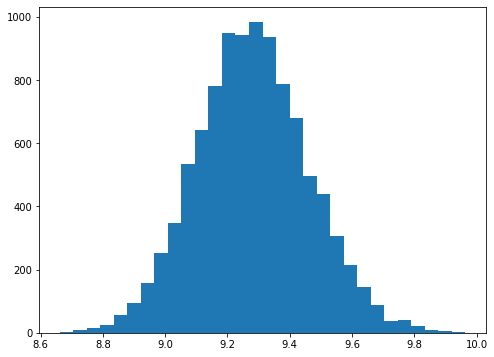

In [64]:
fig, ax = plt.subplots(figsize=(8,6))  # make one subplot (ax) on the figure
ax.hist(bstrap_mean,bins=30)
plt.show()

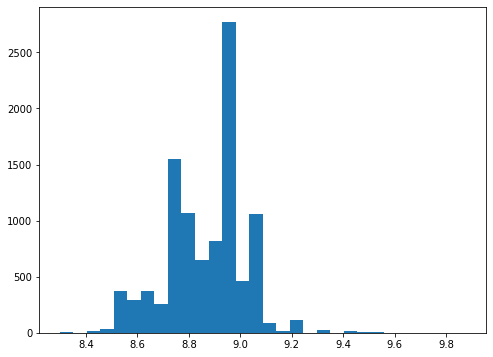

In [65]:
fig, ax = plt.subplots(figsize=(8,6))  # make one subplot (ax) on the figure
ax.hist(bstrap_median,bins=30)
plt.show()

In [66]:
np.mean(bstrap_mean)

9.280799627226463

In [67]:
np.mean(bstrap_median)

8.86660248091603

Take the 2.5 and 97.5 percentiles:

In [68]:
np.quantile(bstrap_mean,0.025),np.quantile(bstrap_mean,0.975)

(8.933930025445292, 9.644142811704834)

compare with theoretical CI: ( 8.622 , 9.314 ), and true mean of 9.086

In [69]:
np.quantile(bstrap_median,0.025),np.quantile(bstrap_median,0.975)

(8.540712468193384, 9.129770992366412)

^^ Also catches the true median of 8.842 

In [70]:
mar['Pace'].median()

8.841921119592875

Bootstrap principle: The sample is to the data as the bootstrap sample is to the sample.

In [71]:
samp2=mar.sample(n=100,random_state=5)
bstrap_mean2=[]
bstrap_median2=[]
xbar2=samp2['Pace'].mean()
mbar2=samp2['Pace'].median()
for i in range(10000):
    newdf2=samp2.sample(frac=1,replace=True)
    xstar2=newdf2['Pace'].mean()
    mstar2=newdf2['Pace'].median()
    bstrap_mean2.append(xstar2)
    bstrap_median2.append(mstar2)

In [72]:
print("samples:",np.round(xbar2,3),np.round(mbar2,3))
print("bootstraps:",np.round(xstar2,3),np.round(mstar2,3))
print("population:",np.round(mar['Pace'].mean(),3),np.round(mar['Pace'].median(),3))

samples: 8.709 8.413
bootstraps: 8.793 8.604
population: 9.086 8.842


In [73]:
np.quantile(bstrap_mean2,0.025),np.quantile(bstrap_mean2,0.975)

(8.421912849872774, 9.010905057251907)

In [74]:
np.quantile(bstrap_median2,0.025),np.quantile(bstrap_median2,0.975)

(8.077290076335878, 8.794529262086513)

Note we missed both here! Got a "bad" sample.

Back to building trees: We wanted to average lots of trees to prevent variance

### Bagging

Sample the training observations (same number) with replacement and fit a decision tree on the resampled data. Each tree only looks at some of the observations.

If the bootstrapped samples are labeled:
$$
1,2,3,\ldots, B,
$$
and the corresponding (deep) trees are 
$$
f^*_1,f^*_2,\ldots,f^*_B,
$$
then for a test observation $x$ we predict:
$$
f^{\text{avg}}(x)=\frac{1}{B}\sum_{i=1}^Bf^*_i(x)
$$
and where the * reminds us that each tree is fit on a bootstrap sample of the original training data set.

In [75]:
from sklearn.ensemble import BaggingRegressor

In [76]:
regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=100,oob_score=True,random_state=0).fit(X_train, y_train)

In [77]:
print("R^2 is {}".format(regr.score(X_test,y_test)),":",":", "MSE is {}".format(mean_squared_error(regr.predict(X_test),y_test)))

R^2 is 0.7942815623053261 : : MSE is 0.3408465508725515


Improvement! OLS $R^2$ was 0.745.

Added Bonus: The bootstrap gives us a way to estimate test-set error without the actual test set. Since the bootstrap samples the training data for each tree, some observations won't be used in the building of the $i$-th tree. 

These observations are called *out-of-bag* observations (OOB) and we can use them as de facto test observations for that tree. In practice, for an observation $x$ we can average the prediction over all trees that leave $x$ OOB. 

***Warning: We still need to use a test set.*** But, this could be useful, say, to determine the optimal number of trees to use.

In [78]:
regr.oob_score_

0.8004440655744886

In [79]:
num_trees=np.linspace(50,500,10)

More trees is generally better (but more expensive) so it's usually a question of diminishing returns.

In [80]:
oob_res=[]
for trs in num_trees:
    res = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=int(trs),oob_score=True,random_state=0).fit(X_train, y_train)
    oob_res.append(res.oob_score_)

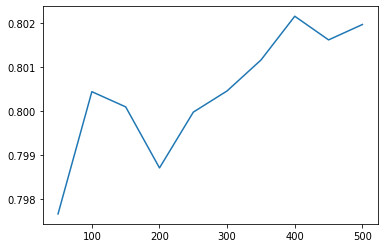

In [81]:
plt.plot(num_trees,oob_res)

Looks like we peak around 400 trees (though only very slightly better than 100 trees).

In [82]:
num_trees[np.argmax(oob_res)]

400.0

In [83]:
opt_trs=int(num_trees[np.argmax(oob_res)])

In [84]:
regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=opt_trs,random_state=0).fit(X_train, y_train)

In [85]:
np.round(regr.score(X_test,y_test),3)

0.795

Test $R^2$ only slightly lower than the OOB score above.

## Random Forests:

Another approach to aggregating trees built on bootstrap samples of the data (like bagging), but with a small tweak. 

Each time we make a split in a tree, we do so using a random sample of the available features. If we have $p$ features, we usually choose $\approx \sqrt{p}$ features.

Why? Decorrelate the trees and allow weaker signals through. The same features won't dominate ***all*** the trees.

Not guaranteed to improve over bagging but can be a big help if we have many correlated features.

In [86]:
from sklearn.ensemble import RandomForestRegressor

In [87]:
rf = RandomForestRegressor(n_estimators=400,max_features='sqrt',random_state=0).fit(X_train,y_train)

In [88]:
rf.score(X_test,y_test)

0.7923380854592477

Very similar to straight bagging here (more examples below). 

We might want to look at feature importances though bagging (and RFs) are not easily interpreted (like a single tree is).

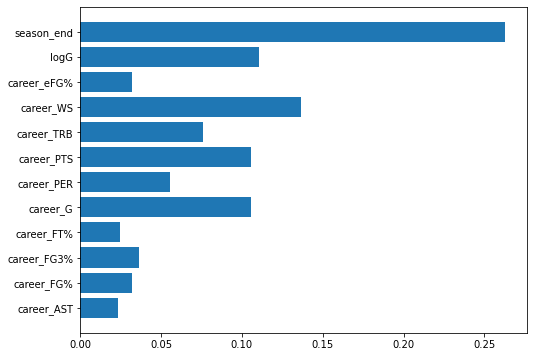

In [89]:
plt.figure(figsize=(8,6))
nfeat=X.shape[1]
plt.barh(np.arange(nfeat),rf.feature_importances_,align='center')
plt.yticks(np.arange(nfeat),list(X.columns))
plt.ylim(-1,nfeat)
plt.show()

### Random Forest Classifier

We have decision tree classifier too, so we can easily build a random forest classifier as well.

Last time we tried *knn* classifier on the breast cancer dataset.

In [90]:
bcd = datasets.load_breast_cancer()
df = pd.DataFrame(bcd['data'], columns=bcd['feature_names'])
df['target'] = bcd['target']

In [91]:
X=df.drop('target',axis=1)
y=df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)

In [92]:
X=df.drop('target',axis=1)
y=df['target']

In [93]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

For *knn*, recall that cross validation gave optimal $k=5$ 

In [94]:
from sklearn.neighbors import KNeighborsClassifier

In [95]:
mod = KNeighborsClassifier(n_neighbors=5)
nb5=mod.fit(X_train_scaled,y_train)

In [96]:
accuracy_score(nb5.predict(X_test_scaled),y_test)

0.9590643274853801

Let's compare with a RF classifier.

In [97]:
from sklearn.ensemble import RandomForestClassifier

Because of how the decision tree algorithm works we don't need scaling, and can use a mix of categorical and quantitative variables.

In [98]:
rfc = RandomForestClassifier(n_estimators=100,max_features='sqrt',random_state=0).fit(X_train,y_train)

In [99]:
accuracy_score(rfc.predict(X_test),y_test)

0.9707602339181286

Wow, we did better right off the shelf. We didn't even tune the number of trees so maybe could do even a bit better.

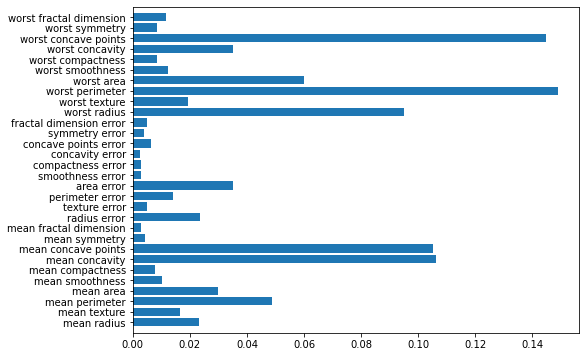

In [100]:
plt.figure(figsize=(8,6))
nfeat=X.shape[1]
plt.barh(np.arange(nfeat),rfc.feature_importances_,align='center')
plt.yticks(np.arange(nfeat),list(X.columns))
plt.ylim(-1,nfeat)
plt.show()

Nice advantages of a Random Forest:
1. Easy to use "off the shelf".
2. Can handle quantitative predictors, categorical predictors, or a mix.
3. Does not require much in the way of parameter tuning.
4. Decouples the trees to handle feature colinearity and allow weaker signals through (by chosing a subset of features at each split ).
5. Generally performs very well (and very similar to bagging if the features are not particularly correlated).
6. Prevents overfitting through averaging (of deep trees).

BUT... we lose interpretability/simplicity of a single tree.

#### Next: Boosting

Again -- use multiple trees to attack the problem. BUT, trees are grown sequentially and are kept small (to prevent overfitting).

Start with a single tree $\hat{f_1}$. 

Then, build a new tree to improve on the prediction of $\hat{f_1}$ by fitting the residuals
$$
y_i-\hat{f_1}(x_i).
$$
We get a new model $\hat{f_2}$ which we add to the old model:
$$
\hat{f_1}+\lambda \hat{f_2}
$$

$\lambda$ is a parameter called the learning rate. It's a small-ish number (0.1, 0.01, 0.001) that slows down the learning process allowing more trees to attack the residuals.

Each small tree is a *weak learner* but they combine into a strong learner.

$$
\hat{f}(x) = \sum_{i=1}^B\lambda \hat{f_i}(x)
$$

In [101]:
from sklearn.ensemble import GradientBoostingRegressor

Let's go back to the NBA salary data (our regression example).

In [102]:
X=pdf.drop('logsalary',axis=1)
y=pdf['logsalary']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)

In [103]:
breg = GradientBoostingRegressor(random_state=0,learning_rate=0.1,n_estimators=500,max_depth=2).fit(X_train,y_train)

In [104]:
breg.score(X_test,y_test)

0.7976215045963253

Tiny improvent over bagging and random forests in this case...

One challenge in building a boosting model is that we have several parameters to choose. 
1. The number of trees.
2. The max depth of each tree.
3. The learning rate.

```sklearn``` has a function to help cross validate over a grid of parameter values. WARNING: It can be slow!!!

In [105]:
from sklearn.model_selection import GridSearchCV

In [106]:
parameters = {'learning_rate':[0.1,0.01], 'n_estimators':[300,400,500],'max_depth':[2,3,4,5]}

In [107]:
bmod = GradientBoostingRegressor(random_state=0)

Might want to stretch legs after running the next cell!

In [108]:
boost_regr = GridSearchCV(bmod, parameters)
boost_regr.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [300, 400, 500]})

Lot's of info in here-- we can pull it all into a data frame...

In [109]:
df=pd.DataFrame.from_dict(boost_regr.cv_results_)

... and pull out the parameter values corresponding to the best CV score. 

In [110]:
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.468535,0.006325,0.002152,0.000225,0.1,2,300,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.763947,0.813919,0.837942,0.730548,0.769824,0.783236,0.038111,11
1,0.631059,0.009240,0.002240,0.000043,0.1,2,400,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.762717,0.812461,0.838303,0.726874,0.757509,0.779573,0.040197,13
2,0.782325,0.009779,0.002502,0.000067,0.1,2,500,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.758568,0.811151,0.837169,0.724618,0.752813,0.776864,0.041122,15
3,0.673772,0.002936,0.002337,0.000067,0.1,3,300,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.750941,0.821028,0.834468,0.731632,0.753607,0.778335,0.041272,14
4,0.918265,0.016135,0.002858,0.000320,0.1,3,400,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.745495,0.814634,0.828732,0.730877,0.748806,0.773709,0.039883,16


In [111]:
df[df['mean_test_score']==df['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,1.18325,0.007956,0.003767,0.000044,0.01,4,400,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.767725,0.828391,0.843972,0.750272,0.784375,0.794947,0.035695,1


In [112]:
best_breg = GradientBoostingRegressor(random_state=0,learning_rate=0.01,n_estimators=400,max_depth=4).fit(X_train,y_train)

In [113]:
np.round(best_breg.score(X_test,y_test),3)

0.799

Very slightly better still. Bagging, RF, boosting are all very similar and outperform Linear Regression / Ridge Regression.

All of our tree based methods can be used for classification too.

#### Recall Decision Tree Classifiers

Essentially, we need a definition of error in a rectangular region to replace RSS. We will assign all points in $R_m$ to the most common class in $R_m$. So, it would seem natural to use the fraction of observations *not* in that most common class (classes $1,2,\ldots, n$) 

$$
1-\max_{k}(\hat{p}_{mk})
$$

This turns out to be not quite sensitive enough to decide cuts. Rather we use the Gini-index:

$$
G=\sum_{k} \hat{p}_{mk}(1-\hat{p}_{mk})
$$


G is small when all class probabilities are near $0$ or $1$.

Plot the two values when there are 2 classes: 

In [114]:
xvals=np.linspace(0,1,100)
yvals1=xvals*(1-xvals)+(1-xvals)*(xvals)
yvals2= 1-np.maximum(xvals,1-xvals)

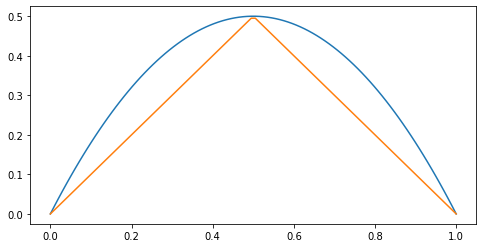

In [115]:
plt.figure(figsize=(8,4))
plt.plot(xvals,yvals1)
plt.plot(xvals,yvals2)
plt.show()

G grows more rapidly as $p$ deviates form 0 or 1: more sensitive to impurity. 

In [116]:
db=pd.read_csv('diabetes.csv')
db.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [117]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [118]:
Xd=db.drop('Outcome',axis=1)
yd=db['Outcome']

In [119]:
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd,yd,test_size=0.3, random_state=5)

In [120]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=400,random_state=0).fit(Xd_train, yd_train)

In [121]:
from sklearn.metrics import accuracy_score

In [122]:
accuracy_score(clf.predict(Xd_test),yd_test)

0.7792207792207793

In [123]:
rfclf = RandomForestClassifier(n_estimators=400, max_features='sqrt',random_state=0).fit(Xd_train,yd_train)

Can do slightly better with max_depth=2

In [124]:
accuracy_score(rfclf.predict(Xd_test),yd_test)

0.7835497835497836

In [125]:
bst_clf = GradientBoostingClassifier(n_estimators=600, learning_rate=0.01,max_depth=1, random_state=0).fit(Xd_train, yd_train)

In [126]:
accuracy_score(bst_clf.predict(Xd_test),yd_test)

0.8008658008658008

In [127]:
single_tree_clf = DecisionTreeClassifier(random_state=0)
path = single_tree_clf.cost_complexity_pruning_path(Xd_train, yd_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [128]:
cvres=[]
for a in ccp_alphas:
    st_clf = DecisionTreeClassifier(random_state=0, ccp_alpha= a)
    cvclf = cross_validate(st_clf, Xd_train, yd_train, cv=5, scoring='accuracy')
    cvres.append(cvclf['test_score'].mean())

In [129]:
np.argmax(cvres)

47

In [130]:
al=ccp_alphas[np.argmax(cvres)]

In [131]:
our_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=al).fit(Xd_train,yd_train)

In [132]:
accuracy_score(our_clf.predict(Xd_test),yd_test)

0.7359307359307359

Bagging improves on a single tree. Boosting and RF both improve on bagging.

Oh yeah-- maybe we should draw a picture of the decision boundary when there are two features since we've done that before for non-tree based methods...

In [133]:
np.random.seed(1)
mX,my = datasets.make_moons(n_samples=500)
jig=np.random.normal(0,.2,size=[500,2])

mdf=pd.DataFrame(mX+jig,columns=['feat1','feat2'])
mdf['Class']=my
mdf.head()

,feat1,feat2,Class
0,0.409860,0.030967,1
1,0.903431,-0.555821,1
2,0.914180,0.574279,0
3,0.447570,0.520823,0
4,2.109126,0.026856,1


In [134]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(mdf[['feat1','feat2']], mdf['Class'], test_size=0.3, random_state=5)
nclf = GradientBoostingClassifier(n_estimators=600, learning_rate=0.01,max_depth=2, random_state=0).fit(Xn_train, yn_train)

In [135]:
xx, yy = np.meshgrid(np.linspace(-2, 3, 500), np.linspace(-1.5, 2, 500))
X_grid = np.c_[xx.ravel(), yy.ravel()]

/home/hamstersnail/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


<Figure size 576x432 with 0 Axes>

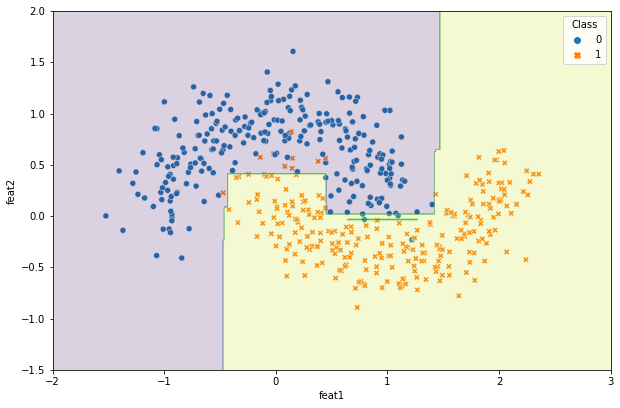

In [136]:
plt.figure(figsize=(8,6))
zz_nn = nclf.predict_proba(X_grid)[:,1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(10, 6.6))
sns.scatterplot(x='feat1',y='feat2',hue='Class',style='Class',data=mdf)
plt.contourf(xx, yy, zz_nn > 0.5, alpha=0.2)
plt.show()

Of course, there's not really that much room to shine with only two features...

Here's another example. We have 10 features which are all independent $N(0,1)$ observations. If the sum of the 10 exceeds 9.34, then class =1, else class = -1.

In [137]:
from sklearn.datasets import make_hastie_10_2
Xh, yh = make_hastie_10_2(random_state=0)

In [138]:
Xh.shape

(12000, 10)

In [139]:
yh[0:10]

array([ 1., -1.,  1., -1.,  1., -1., -1., -1.,  1., -1.])

Plotting column 3 versus column 7 colored by class... don't see much there!

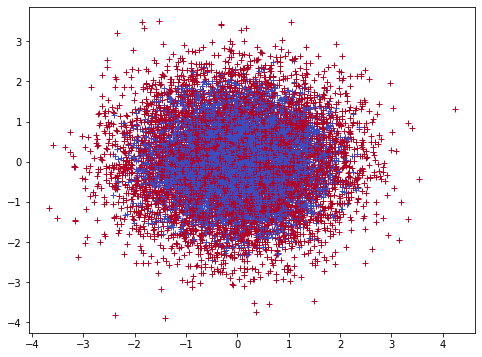

In [140]:
plt.figure(figsize=(8,6))
plt.scatter(Xh[:,3], Xh[:,7], marker="+",linewidths=1,c=yh, cmap=plt.cm.coolwarm)
plt.show()

In [141]:
Xh_train, Xh_test, yh_train, yh_test = train_test_split(Xh,yh,test_size=0.3, random_state=5)

In [142]:
rfh_clf = RandomForestClassifier(n_estimators=600,max_depth=2, oob_score=True,max_features='sqrt',random_state=0).fit(Xh_train,yh_train)

In [143]:
accuracy_score(rfh_clf.predict(Xh_test),yh_test)

0.7375

Since random forest classifier is built on bootstrapoping it can give OOB score also:

In [144]:
rfh_clf.oob_score_

0.7295238095238096

In [145]:
bst_clf = GradientBoostingClassifier(n_estimators=600, learning_rate=0.01,max_depth=2, random_state=0).fit(Xh_train, yh_train)

In [146]:
accuracy_score(bst_clf.predict(Xh_test),yh_test)

0.8677777777777778

In [147]:
from sklearn.linear_model import LogisticRegression

In [148]:
lm = LogisticRegression(random_state=0).fit(Xh_train, yh_train)

In [149]:
accuracy_score(lm.predict(Xh_test),yh_test)

0.5316666666666666

In [150]:
fsh=pd.read_csv('BigFish.csv')

In [151]:
fsh.shape

(159, 7)

In [152]:
fsh.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [153]:
fsh=pd.get_dummies(fsh)

In [154]:
fsh.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0


In [155]:
Xf=fsh.drop('Weight',axis=1)
yf=fsh['Weight']

In [156]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf,yf,test_size=0.3, random_state=5)

In [157]:
rf_fsh = RandomForestRegressor(n_estimators=200,max_features='sqrt',random_state=0).fit(Xf_train,yf_train)

In [158]:
rf_fsh.score(Xf_test,yf_test)

0.9767773367425386

(Ridge regression gets r^2=.875 ish)

(-1.0, 12.0)

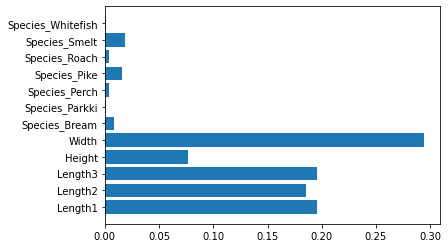

In [159]:
nfeat=Xf.shape[1]
plt.barh(np.arange(nfeat),rf_fsh.feature_importances_,align='center')
plt.yticks(np.arange(nfeat),list(Xf.columns))
plt.ylim(-1,nfeat)

## Sandbox

* Breast Cancer data: Try knn and tree-based classifiers
* Boston housing: try tree based regressors for MEDV
* Carseats define a Class on Sales where CLass = 1 if Sales > 8 and 0 otherwise. Compare tree-based classifiers to knn.
* Carseats II: Perform tree-based regression on Sales.
* Try tree-based classifiers on the two moons (arcs) dataset and the circular HW dataset
* Try predicting Target in the ```classify_me.csv``` file 

In [160]:
from sklearn import datasets

In [161]:
bcd,ycd=sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
bcd.head()

NameError: name 'sklearn' is not defined

In [ ]:
bcd.shape

In [ ]:
ycd.head()

In [ ]:
Xbos,ybos=datasets.load_boston(return_X_y=True)